In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from IPython.display import display, Math, Latex

# дано
<div>Длины труб(d) их их диаметры(d)</div>
<div>Напор(Н)</div>
<div>Коэффициент $\alpha$</div>

In [2]:
given_data = pd.DataFrame({
    "l" : [65, 150, 220],
    "d" : [0.6, 0.9, 0.7],
}, index = ['L1', 'L2', 'L3'])
H = 35
alpha = 1
given_data

,l,d
L1,65,0.6
L2,150,0.9
L3,220,0.7


# используемые формулы
Путевые потери $\lambda*l_i / d_i^{0.3}, \lambda = 0.021/d_i$ <br>
Потери на резкое расширение $1 - (\omega_1/\omega_2)^2$ <br>
Потери на резское сужение $0.5 * (1 - (\omega_2/\omega_1)^2)$ <br>
Площадь сечения $\pi * d^2/4$ <br>
Отношение скоростей $v_3/v_1, v_3/v_2$ <br>
Кинетическая энергия $v^2 / (2 * g)$ <br>

In [3]:
pump_loss = lambda l,d : 0.021*l/(d**1.3)
expansion_loss = lambda d1, d2: (1 - (d1/d2)**2)
constriction_loss = lambda d1, d2: 0.5*(1 - (d2/d1)**2)
w = lambda d: np.pi * d**2 / 4
beta = lambda d: given_data['d'][2]**2 / d**2
kinetic_en = lambda v: v**2/(2*9.81)

In [4]:
Sheet = pd.DataFrame({
    "Потери" : ['Вход', 'по L1', 'резкое расширение', 'по L2', 'резкое сужение', 'по L3/2', 'задвижка', 'по L3/2', 'Выход'],
    'zeta' : [0.5,
                pump_loss(*given_data.loc['L1']),
                expansion_loss(*given_data['d'][:2]),
                pump_loss(*given_data.loc['L2']),
                constriction_loss(*given_data['d'][1:3]),
                pump_loss(*given_data.loc['L3'])/2,
                2.06,
                pump_loss(*given_data.loc['L3'])/2,
                1],
    'beta^2' : [
                beta(given_data['d'][0])**2,
                beta(given_data['d'][0])**2,
                beta(given_data['d'][1])**2,
                beta(given_data['d'][1])**2,
                1,
                1,
                1,
                1,
                1,],
})

In [5]:
Sheet['zeta*beta^2'] = Sheet['zeta']*Sheet['beta^2']

zb_sum = Sheet['zeta*beta^2'].sum()
v3 = sqrt(2*9.81*H/(1 + zb_sum))
v2 = beta(given_data['d'][1])*v3
v1 = beta(given_data['d'][0])*v3
Sheet['a*v^2/2g'] = list(map(
    kinetic_en,
    [v1, v1, v2, v2, v3, v3, v3, v3, v3]
))
Sheet['hf'] = Sheet['zeta'] * Sheet['a*v^2/2g']
Sheet['Loss sum'] = Sheet['hf'].cumsum()

In [6]:
Sheet

,Потери,zeta,beta^2,zeta*beta^2,a*v^2/2g,hf,Loss sum
0,Вход,0.500000,1.852623,0.926312,3.418625,1.709312,1.709312
1,по L1,2.651771,1.852623,4.912733,3.418625,9.065411,10.774723
2,резкое расширение,0.555556,0.365950,0.203306,0.675284,0.375158,11.149881
3,по L2,3.612395,0.365950,1.321957,0.675284,2.439393,13.589273
4,резкое сужение,0.197531,1.000000,0.197531,1.845289,0.364501,13.953775
5,по L3/2,3.672692,1.000000,3.672692,1.845289,6.777177,20.730952
6,задвижка,2.060000,1.000000,2.060000,1.845289,3.801294,24.532246
7,по L3/2,3.672692,1.000000,3.672692,1.845289,6.777177,31.309423
8,Выход,1.000000,1.000000,1.000000,1.845289,1.845289,33.154711


In [7]:
Sheet['a*v^2/2g'][8] + Sheet['Loss sum'][8]

35.00000000000001

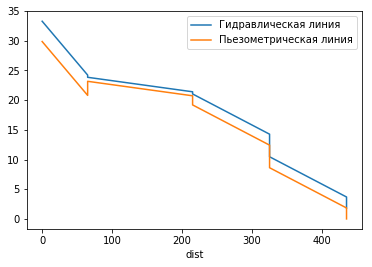

In [11]:
Result = pd.DataFrame()
Result['dist'] = pd.Series([0, given_data['l'][0], #tube1
                           0, given_data['l'][1], #tube2
                           0, given_data['l'][2]/2, 0, given_data['l'][2]/2, 0 #tube3
                          ]).cumsum()
Result['Гидравлическая линия'] = H - Sheet['Loss sum']
Result['Пьезометрическая линия'] = Result['Гидравлическая линия'] - Sheet['a*v^2/2g']

Result.plot(x = 'dist')

In [9]:
Result

,dist,Гидравлическая линия,Пьезометрическая линия
0,0.0,33.290688,2.987206e+01
1,65.0,24.225277,2.080665e+01
2,65.0,23.850119,2.317484e+01
3,215.0,21.410727,2.073544e+01
4,215.0,21.046225,1.920094e+01
5,325.0,14.269048,1.242376e+01
6,325.0,10.467754,8.622465e+00
7,435.0,3.690577,1.845289e+00
8,435.0,1.845289,-4.218847e-15


In [10]:
zb_sum

17.96722315895501